In [1]:
!nvidia-smi

Tue Mar 11 19:34:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 4000 Ada Gene...    Off |   00000000:01:00.0 Off |                  Off |
| 30%   31C    P8             11W /  130W |     147MiB /  20475MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
%cd ..

from mingpt.bpe import BPETokenizer
from mingpt.model import GPT

import torch
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

/users/eleves-a/2022/brahim.touayouch/projects/MiniGPT/.venv/lib64/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/users/eleves-a/2022/brahim.touayouch/projects/MiniGPT


/users/eleves-a/2022/brahim.touayouch/projects/MiniGPT/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
class StoryDataset:
    def __init__(self, data, tokenizer, block_size=128):
        self.tokenizer = tokenizer
        self.block_size = block_size
        self.data1 = [
            self.format_example(data_point["text"]) for data_point in data
        ]

    def format_example(self, text):
        tokens = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=self.block_size)
        tokens = tokens.squeeze(0)
        
        return tokens

    def __len__(self):
        return len(self.data1)

    def __getitem__(self, idx):
        """
        Returns:
            x (torch.Tensor): Input tokens (question + answer prompt).
            y (torch.Tensor): Target tokens (shifted output).
        """
        if isinstance(idx, int):
            tokens = self.data1[idx]
            x = tokens[:-1].clone().detach()
            y = tokens[1:].clone().detach()
            return x, y
        
        elif isinstance(idx, list) or isinstance(idx, torch.Tensor):
            batch_tokens = [self.data1[i] for i in idx]
            x_batch = [tokens[:-1].clone().detach() for tokens in batch_tokens]
            y_batch = [tokens[1:].clone().detach() for tokens in batch_tokens]
            return x_batch, y_batch
        
        else:
            raise TypeError(f"Invalid index type: {type(idx)}")


In [5]:
data = load_dataset('roneneldan/TinyStories')
data_frame = pd.DataFrame(data["train"])

In [6]:
data_frame

,text
0,"One day, a little girl named Lily found a need..."
1,"Once upon a time, there was a little car named..."
2,"One day, a little fish named Fin was swimming ..."
3,"Once upon a time, in a land full of trees, the..."
4,"Once upon a time, there was a little girl name..."
...,...
2119714,"Once upon a time, in a small town, there lived..."
2119715,"Once upon a time, there was a little boy named..."
2119716,"Once upon a time, there was a big tree. Under ..."
2119717,"Once upon a time, there was a little girl name..."


In [7]:
data_frame.iloc[0]['text']

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.'

In [8]:
train_testvalid = data["train"].train_test_split(test_size=0.9, seed=42)

test_valid = train_testvalid["test"].train_test_split(test_size=0.5, seed=42)

train_data = train_testvalid["train"]
val_data = test_valid["train"]
test_data = test_valid["test"]

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

Train size: 211971, Validation size: 953874, Test size: 953874


In [9]:
tokenizer = BPETokenizer()

train_dataset = StoryDataset(train_data.select(range(8000)), tokenizer=tokenizer, block_size=256)
test_dataset = StoryDataset(test_data.select(range(4000)), tokenizer=tokenizer, block_size=256)
val_dataset = StoryDataset(val_data.select(range(3000)), tokenizer=tokenizer, block_size=256)

In [10]:
model_type = 'gpt2'
device = 'cuda'

model = GPT.from_pretrained(model_type)
model.to(device)

number of parameters: 124.44M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(

In [11]:
def generate(prompt='', num_samples=1, steps=20, do_sample=True):
    tokenizer = BPETokenizer()

    if prompt == '':
        x = torch.tensor([[tokenizer.encoder.encoder['<|endoftext|>']]], dtype=torch.long)
    else:
        x = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=len(prompt.split())).to(device)

    x = x.expand(num_samples, -1)

    y = model.generate(x, max_new_tokens=steps, do_sample=do_sample, top_k=40)

    endoftext_token_id = tokenizer.encoder.encoder['<|endoftext|>']

    for i in range(num_samples):
        out = tokenizer.decode(y[i].cpu().squeeze())

        out_tokens = y[i].cpu().squeeze().tolist()
        
        if endoftext_token_id in out_tokens:
            end_pos = out_tokens.index(endoftext_token_id)
            out = tokenizer.decode(y[i].cpu().squeeze()[:end_pos])

        print('\n' + '-' * 80)
        print(out)

# Finetuning

In [12]:
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-5
train_config.batch_size = 24
train_config.max_iters = 500
train_config.num_workers = 0
train_config.eval_interval = 1
train_config.log_iter = 100
def collate_fn(batch):
    x_batch, y_batch = zip(*batch)
    return torch.stack(x_batch), torch.stack(y_batch)

train_config.collate_fn = collate_fn
trainer = Trainer(train_config, model, train_dataset, val_dataset)

Running on device cuda


In [13]:
losses = []
def batch_end_callback(trainer):
    losses.append(trainer.loss.item())
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}\n")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

Training Progress:  80%|████████  | 401/500 [3:12:04<47:39, 28.89s/it]

Validation Loss: 1.3612


Training Progress:  80%|████████  | 402/500 [3:12:32<47:02, 28.80s/it]

iter_dt 0.00ms; iter 400: train loss 1.42212

Validation Loss: 1.3607


Training Progress:  81%|████████  | 403/500 [3:13:01<46:34, 28.81s/it]

Validation Loss: 1.3605


Training Progress:  81%|████████  | 404/500 [3:13:30<46:06, 28.81s/it]

Validation Loss: 1.3605


Training Progress:  81%|████████  | 405/500 [3:13:59<45:37, 28.82s/it]

Validation Loss: 1.3605


Training Progress:  81%|████████  | 406/500 [3:14:28<45:08, 28.82s/it]

Validation Loss: 1.3603


Training Progress:  81%|████████▏ | 407/500 [3:14:57<44:39, 28.82s/it]

Validation Loss: 1.3600


Training Progress:  82%|████████▏ | 408/500 [3:15:25<44:10, 28.81s/it]

Validation Loss: 1.3595


Training Progress:  82%|████████▏ | 409/500 [3:15:54<43:41, 28.81s/it]

Validation Loss: 1.3590


Training Progress:  82%|████████▏ | 410/500 [3:16:23<43:13, 28.81s/it]

Validation Loss: 1.3581


Training Progress:  82%|████████▏ | 411/500 [3:16:52<42:43, 28.80s/it]

Validation Loss: 1.3572


Training Progress:  82%|████████▏ | 412/500 [3:17:21<42:13, 28.79s/it]

Validation Loss: 1.3565


Training Progress:  83%|████████▎ | 413/500 [3:17:49<41:44, 28.79s/it]

Validation Loss: 1.3560


Training Progress:  83%|████████▎ | 414/500 [3:18:18<41:15, 28.78s/it]

Validation Loss: 1.3559


Training Progress:  83%|████████▎ | 415/500 [3:18:47<40:46, 28.78s/it]

Validation Loss: 1.3560


Training Progress:  83%|████████▎ | 416/500 [3:19:16<40:17, 28.78s/it]

Validation Loss: 1.3562


Training Progress:  83%|████████▎ | 417/500 [3:19:44<39:48, 28.78s/it]

Validation Loss: 1.3566


Training Progress:  84%|████████▎ | 418/500 [3:20:13<39:19, 28.78s/it]

Validation Loss: 1.3570


Training Progress:  84%|████████▍ | 419/500 [3:20:42<38:50, 28.77s/it]

Validation Loss: 1.3581


Training Progress:  84%|████████▍ | 420/500 [3:21:11<38:21, 28.77s/it]

Validation Loss: 1.3589


Training Progress:  84%|████████▍ | 421/500 [3:21:40<37:53, 28.77s/it]

Validation Loss: 1.3589


Training Progress:  84%|████████▍ | 422/500 [3:22:08<37:24, 28.78s/it]

Validation Loss: 1.3582


Training Progress:  85%|████████▍ | 423/500 [3:22:37<36:55, 28.78s/it]

Validation Loss: 1.3574


Training Progress:  85%|████████▍ | 424/500 [3:23:06<36:26, 28.78s/it]

Validation Loss: 1.3562


Training Progress:  85%|████████▌ | 425/500 [3:23:35<35:58, 28.78s/it]

Validation Loss: 1.3550


Training Progress:  85%|████████▌ | 426/500 [3:24:03<35:30, 28.79s/it]

Validation Loss: 1.3540


Training Progress:  85%|████████▌ | 427/500 [3:24:32<35:02, 28.80s/it]

Validation Loss: 1.3530


Training Progress:  86%|████████▌ | 428/500 [3:25:01<34:34, 28.81s/it]

Validation Loss: 1.3523


Training Progress:  86%|████████▌ | 429/500 [3:25:30<34:05, 28.81s/it]

Validation Loss: 1.3519


Training Progress:  86%|████████▌ | 430/500 [3:25:59<33:37, 28.82s/it]

Validation Loss: 1.3519


Training Progress:  86%|████████▌ | 431/500 [3:26:28<33:08, 28.82s/it]

Validation Loss: 1.3521


Training Progress:  86%|████████▋ | 432/500 [3:26:56<32:39, 28.82s/it]

Validation Loss: 1.3523


Training Progress:  87%|████████▋ | 433/500 [3:27:25<32:11, 28.82s/it]

Validation Loss: 1.3526


Training Progress:  87%|████████▋ | 434/500 [3:27:54<31:42, 28.82s/it]

Validation Loss: 1.3532


Training Progress:  87%|████████▋ | 435/500 [3:28:23<31:13, 28.82s/it]

Validation Loss: 1.3538


Training Progress:  87%|████████▋ | 436/500 [3:28:52<30:44, 28.83s/it]

Validation Loss: 1.3543


Training Progress:  87%|████████▋ | 437/500 [3:29:21<30:15, 28.82s/it]

Validation Loss: 1.3548


Training Progress:  88%|████████▊ | 438/500 [3:29:49<29:47, 28.82s/it]

Validation Loss: 1.3549


Training Progress:  88%|████████▊ | 439/500 [3:30:18<29:18, 28.82s/it]

Validation Loss: 1.3549


Training Progress:  88%|████████▊ | 440/500 [3:30:47<28:49, 28.82s/it]

Validation Loss: 1.3544


Training Progress:  88%|████████▊ | 441/500 [3:31:16<28:20, 28.82s/it]

Validation Loss: 1.3538


Training Progress:  88%|████████▊ | 442/500 [3:31:45<27:51, 28.82s/it]

Validation Loss: 1.3538


Training Progress:  89%|████████▊ | 443/500 [3:32:13<27:22, 28.82s/it]

Validation Loss: 1.3540


Training Progress:  89%|████████▉ | 444/500 [3:32:42<26:54, 28.83s/it]

Validation Loss: 1.3545


Training Progress:  89%|████████▉ | 445/500 [3:33:11<26:25, 28.83s/it]

Validation Loss: 1.3539


Training Progress:  89%|████████▉ | 446/500 [3:33:40<25:56, 28.83s/it]

Validation Loss: 1.3527


Training Progress:  89%|████████▉ | 447/500 [3:34:09<25:28, 28.83s/it]

Validation Loss: 1.3511


Training Progress:  90%|████████▉ | 448/500 [3:34:38<24:59, 28.83s/it]

Validation Loss: 1.3509


Training Progress:  90%|████████▉ | 449/500 [3:35:06<24:30, 28.83s/it]

Validation Loss: 1.3516


Training Progress:  90%|█████████ | 450/500 [3:35:35<24:01, 28.83s/it]

Validation Loss: 1.3529


Training Progress:  90%|█████████ | 451/500 [3:36:04<23:32, 28.82s/it]

Validation Loss: 1.3533


Training Progress:  90%|█████████ | 452/500 [3:36:33<23:03, 28.82s/it]

Validation Loss: 1.3530


Training Progress:  91%|█████████ | 453/500 [3:37:02<22:34, 28.81s/it]

Validation Loss: 1.3524


Training Progress:  91%|█████████ | 454/500 [3:37:30<22:05, 28.81s/it]

Validation Loss: 1.3515


Training Progress:  91%|█████████ | 455/500 [3:37:59<21:36, 28.80s/it]

Validation Loss: 1.3512


Training Progress:  91%|█████████ | 456/500 [3:38:28<21:07, 28.80s/it]

Validation Loss: 1.3507


Training Progress:  91%|█████████▏| 457/500 [3:38:57<20:38, 28.80s/it]

Validation Loss: 1.3503


Training Progress:  92%|█████████▏| 458/500 [3:39:26<20:09, 28.80s/it]

Validation Loss: 1.3499


Training Progress:  92%|█████████▏| 459/500 [3:39:54<19:40, 28.80s/it]

Validation Loss: 1.3496


Training Progress:  92%|█████████▏| 460/500 [3:40:23<19:11, 28.80s/it]

Validation Loss: 1.3491


Training Progress:  92%|█████████▏| 461/500 [3:40:52<18:43, 28.80s/it]

Validation Loss: 1.3483


Training Progress:  92%|█████████▏| 462/500 [3:41:21<18:14, 28.80s/it]

Validation Loss: 1.3480


Training Progress:  93%|█████████▎| 463/500 [3:41:50<17:45, 28.80s/it]

Validation Loss: 1.3479


Training Progress:  93%|█████████▎| 464/500 [3:42:18<17:16, 28.80s/it]

Validation Loss: 1.3483


Training Progress:  93%|█████████▎| 465/500 [3:42:47<16:48, 28.80s/it]

Validation Loss: 1.3488


Training Progress:  93%|█████████▎| 466/500 [3:43:16<16:19, 28.80s/it]

Validation Loss: 1.3493


Training Progress:  93%|█████████▎| 467/500 [3:43:45<15:50, 28.80s/it]

Validation Loss: 1.3494


Training Progress:  94%|█████████▎| 468/500 [3:44:14<15:21, 28.80s/it]

Validation Loss: 1.3493


Training Progress:  94%|█████████▍| 469/500 [3:44:42<14:52, 28.80s/it]

Validation Loss: 1.3487


Training Progress:  94%|█████████▍| 470/500 [3:45:11<14:24, 28.80s/it]

Validation Loss: 1.3486


Training Progress:  94%|█████████▍| 471/500 [3:45:40<13:55, 28.80s/it]

Validation Loss: 1.3480


Training Progress:  94%|█████████▍| 472/500 [3:46:09<13:26, 28.79s/it]

Validation Loss: 1.3474


Training Progress:  95%|█████████▍| 473/500 [3:46:38<12:57, 28.80s/it]

Validation Loss: 1.3470


Training Progress:  95%|█████████▍| 474/500 [3:47:06<12:28, 28.80s/it]

Validation Loss: 1.3470


Training Progress:  95%|█████████▌| 475/500 [3:47:35<11:59, 28.80s/it]

Validation Loss: 1.3475


Training Progress:  95%|█████████▌| 476/500 [3:48:04<11:31, 28.80s/it]

Validation Loss: 1.3482


Training Progress:  95%|█████████▌| 477/500 [3:48:33<11:02, 28.80s/it]

Validation Loss: 1.3487


Training Progress:  96%|█████████▌| 478/500 [3:49:02<10:33, 28.80s/it]

Validation Loss: 1.3488


Training Progress:  96%|█████████▌| 479/500 [3:49:30<10:04, 28.80s/it]

Validation Loss: 1.3486


Training Progress:  96%|█████████▌| 480/500 [3:49:59<09:36, 28.84s/it]

Validation Loss: 1.3484


Training Progress:  96%|█████████▌| 481/500 [3:50:28<09:08, 28.86s/it]

Validation Loss: 1.3483


Training Progress:  96%|█████████▋| 482/500 [3:50:57<08:39, 28.88s/it]

Validation Loss: 1.3486


Training Progress:  97%|█████████▋| 483/500 [3:51:26<08:10, 28.85s/it]

Validation Loss: 1.3485


Training Progress:  97%|█████████▋| 484/500 [3:51:55<07:41, 28.83s/it]

Validation Loss: 1.3479


Training Progress:  97%|█████████▋| 485/500 [3:52:24<07:12, 28.82s/it]

Validation Loss: 1.3472


Training Progress:  97%|█████████▋| 486/500 [3:52:52<06:43, 28.82s/it]

Validation Loss: 1.3465


Training Progress:  97%|█████████▋| 487/500 [3:53:21<06:14, 28.81s/it]

Validation Loss: 1.3460


Training Progress:  98%|█████████▊| 488/500 [3:53:50<05:45, 28.81s/it]

Validation Loss: 1.3457


Training Progress:  98%|█████████▊| 489/500 [3:54:19<05:16, 28.81s/it]

Validation Loss: 1.3452


Training Progress:  98%|█████████▊| 490/500 [3:54:48<04:48, 28.81s/it]

Validation Loss: 1.3448


Training Progress:  98%|█████████▊| 491/500 [3:55:16<04:19, 28.81s/it]

Validation Loss: 1.3446


Training Progress:  98%|█████████▊| 492/500 [3:55:45<03:50, 28.81s/it]

Validation Loss: 1.3446


Training Progress:  99%|█████████▊| 493/500 [3:56:14<03:21, 28.81s/it]

Validation Loss: 1.3446


Training Progress:  99%|█████████▉| 494/500 [3:56:43<02:52, 28.80s/it]

Validation Loss: 1.3445


Training Progress:  99%|█████████▉| 495/500 [3:57:12<02:24, 28.80s/it]

Validation Loss: 1.3446


Training Progress:  99%|█████████▉| 496/500 [3:57:40<01:55, 28.80s/it]

Validation Loss: 1.3446


Training Progress:  99%|█████████▉| 497/500 [3:58:09<01:26, 28.80s/it]

Validation Loss: 1.3442


Training Progress: 100%|█████████▉| 498/500 [3:58:38<00:57, 28.80s/it]

Validation Loss: 1.3438


Training Progress: 100%|█████████▉| 499/500 [3:59:07<00:28, 28.80s/it]

Validation Loss: 1.3438


Training Progress: 100%|██████████| 500/500 [3:59:36<00:00, 28.80s/it]

Validation Loss: 1.3440


Training Progress: 100%|██████████| 500/500 [4:00:04<00:00, 28.81s/it]

Training finished!


# Save the model

In [ ]:
save_path = "./saved_model"
model.save(save_path)

# Evaluations

In [14]:
print(losses)
print(trainer.val_losses)

[5.05987024307251, 3.161884307861328, 2.2083654403686523, 1.9456908702850342, 1.7692450284957886, 1.7914812564849854, 1.794234275817871, 1.8392390012741089, 1.9325907230377197, 1.863972544670105, 1.7191802263259888, 1.7072527408599854, 1.7058500051498413, 1.634757161140442, 1.7632590532302856, 1.7957216501235962, 1.6902329921722412, 1.7192598581314087, 1.7313144207000732, 1.7205241918563843, 1.7780678272247314, 1.5276695489883423, 1.7076867818832397, 1.6744614839553833, 1.500742793083191, 1.5596320629119873, 1.6117428541183472, 1.7145359516143799, 1.7228761911392212, 1.6198005676269531, 1.490304708480835, 1.5954926013946533, 1.570942759513855, 1.5433745384216309, 1.5889798402786255, 1.702252745628357, 1.6106988191604614, 1.5647367238998413, 1.5925887823104858, 1.580786943435669, 1.4911737442016602, 1.6102832555770874, 1.5543930530548096, 1.6151669025421143, 1.5412770509719849, 1.5573419332504272, 1.5890618562698364, 1.581226110458374, 1.5294193029403687, 1.694804310798645, 1.5629749298

### Training and Validation Loss

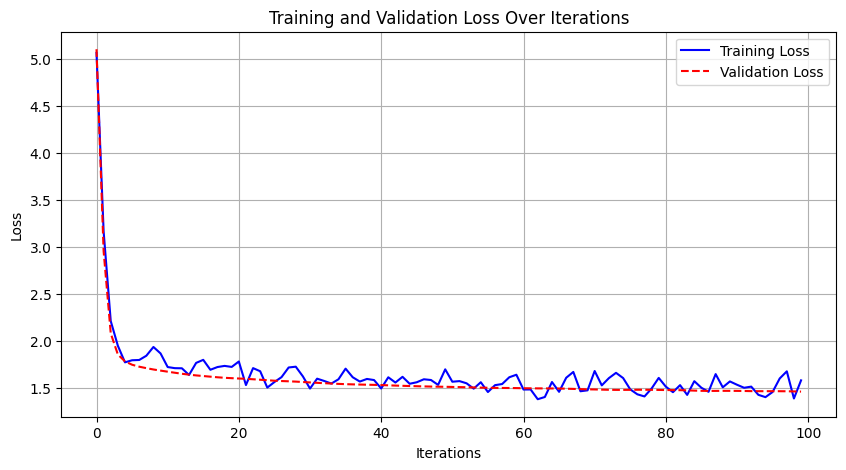

In [3]:
def plot_loss(iterations, train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    
    plt.plot(iterations, train_losses, label="Training Loss", color='blue')
    
    plt.plot(iterations, val_losses, label="Validation Loss", color='red', linestyle='dashed')
    
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Iterations")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(range(100), losses[:100], trainer.val_losses[:100])